EPITA 2019 MLRF practice_02-01_color-histogram v2019-05-11_175957 by Joseph CHAZALON

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Practice 02 part 01: (Indexed) color histograms as global descriptors

The principle is very simple and illustrated below: from a set of pixels we count how many times each color appears, and we build an histogram of the frequencies (as opposed to raw counts, because we normalize the values) of occurences of colors.

Here are some examples of the histograms we can compute from some bubbles:
![hist1](img/hist1.png)
![hist2](img/hist2.png)
![hist3](img/hist3.png)

Using such descriptors, we can very easily group similar bubbles with a reasonnable confidence.

This part contains the following steps:
1. Color quantization: reduce the colors of the bubbles.
2. Compute the color histogram of each bubble.
3. Compute the distance matrix between each bubble, using its color histogram, and store it for the next part.
4. Visualize the bubbles in an interesting way using hierarchical clustering.


## 1. Color quantization
It is hard to compare the full RGB histogram of an image (a bubble) with the histogram of another, so we will first **reduce the number of colors** used to represent each image.


Color quantization is a practical application of [vector quantization](https://en.wikipedia.org/wiki/Vector_quantization) where each color is replaced by the closest color in a pre-defined palette.


We have two options here:
1. build a palette manually
2. use a clustering technique to build it automatically

We will use **K-Means clustering** to discover a reduced set of representative colors.

<div style="overflow: auto; border-style: solid; border-color: red; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="stop" src='img/stop.png' style='float: left; margin-right: 20px'>
    
**If you do not manage to build the palette automatically, then build your codebook manually and convert the color of the images using [`scipy.cluster.vq.vq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html).**
</div>

### 1.1. Sample some pixels
Because K-Means is a costly algorithm, we will first sample our pixels (viewing them as plain 3-dimensional vectors) to avoid filling up our memory during KMeans fitting.

We will use the base image to facilitate the sampling, because otherwise we would have to select pixels from every bubble image and merge the results.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Use the large (200 DPI) poster image WITH ITS MASK to sample some pixels. 5000 is a good number of samples.**

*Tips:*
- The code for loading the image is provided below to save you time.
- `poster[poster_mask]` returns a set of valid pixels.
- You can use [`np.random.choice`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html#numpy.random.choice) to select **random indices** and then use those indices to select random pixels.
</div>

In [1]:
# deactivate buggy jupyter completion
%config Completer.use_jedi = False

In [2]:
import numpy as np
import cv2
from skimage.color import rgb2hsv, hsv2rgb
import skimage
import matplotlib.pyplot as plt
%matplotlib inline
import os

np.random.seed = 1

In [3]:
# prof
PATH_TO_RESOURCES = "res/twin_it"

In [4]:
# load the base image and its mask.
poster = skimage.io.imread(os.path.join(PATH_TO_RESOURCES, "twin_it_200dpi.png"))
poster_mask = skimage.io.imread(os.path.join(PATH_TO_RESOURCES, "mask_bubbles.png")) > 0
poster.shape, poster.dtype, poster_mask.shape, poster_mask.dtype

((5956, 4153, 3), dtype('uint8'), (5956, 4153), dtype('bool'))

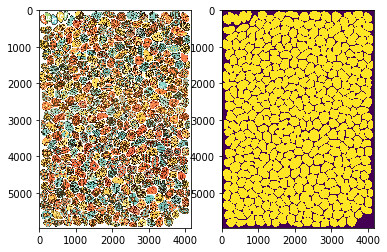

In [5]:
plt.subplot(1,2,1)
plt.imshow(poster)
plt.subplot(1,2,2)
plt.imshow(poster_mask)

In [6]:
# sample 5000 pixels
poster_masked = poster[poster_mask]
print("shape poster_masked: ", poster_masked.shape)
sample_indices = np.random.choice(len(poster_masked), 5000, replace=False)
sample_pixels = poster_masked[sample_indices]
sample_pixels.shape, sample_pixels.dtype

shape poster_masked:  (20012105, 3)


((5000, 3), dtype('uint8'))

### 1.3. K-Means clustering stage 1/2: fitting
OK, we are now ready to perform K-Means clustering.

In [7]:
from sklearn.cluster import KMeans

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Use K-Means clustering to compute the color palette. Use a small value like 7 for the number of target colors.**

Tip:
- Set the `random_state` parameter to some fixed value to ensure the reproducibility of your results.
- Use the `fit` method to compute cluster centers.
- The cluster centers will be available with `kmeans.cluster_centers_`.
</div>

In [8]:
# prof
# compute the new color palette
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(sample_pixels)
kmeans.cluster_centers_  # Those are HSV colors

array([[247.22894737, 230.86052632, 164.01842105],
       [ 87.00077882,  63.89563863,  30.71261682],
       [240.64441748, 134.22815534,  84.5461165 ],
       [150.35914553, 200.67556742, 187.1682243 ],
       [141.9038961 , 113.50909091,  81.31948052],
       [ 43.78424242,  20.66181818,   5.15030303],
       [246.2875226 , 205.93490054,  95.10488246]])

### 1.4. K-Means clustering stage 2/2: projection
The [`KMeans` class](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) provided by scikit-learn has two methods for transforming our data:
- `transform`
- `predict`

**Make sure you understand the difference between those two functions.**

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Use the `KMeans` object and super fancy Numpy indexing to create a new image where the color of each pixel is the color of the closest cluster to the original pixel color.**

Tip:
- To not forget to mask the background of the image (set it to white for instance).
- Start by producing a new image with cluster labels instead of color values.
- Then create a color lookup table using cluster centers (make sure to use `np.uint8` value to avoid issues with later conversion.
- Finally use Numpy advanced indexing to apply the LUT to the image with cluster labels.
</div>

In [9]:
# Some extra help about the LUT thing:
my_LUT = np.array([(255, 0, 0),  # cluster red
                   (0, 0, 255)]) # cluster blue
my_label_image = np.array([[0,1,0,1,1]])
my_LUT[my_label_image]
# The result contains values from `my_LUT` and has the shape of `my_label_image`. Simply beautiful.

array([[[255,   0,   0],
        [  0,   0, 255],
        [255,   0,   0],
        [  0,   0, 255],
        [  0,   0, 255]]])

In [10]:
# Here are the labels of our 5000 sampled pixel
kmeans.labels_

array([5, 6, 1, ..., 3, 2, 3], dtype=int32)

In [11]:
# Here are the label of all the pixels in the bubbles
label_map = kmeans.predict(poster_masked)
label_map

array([0, 3, 4, ..., 4, 4, 3], dtype=int32)

array([[247, 230, 164],
       [ 87,  63,  30],
       [240, 134,  84],
       [150, 200, 187],
       [141, 113,  81],
       [ 43,  20,   5],
       [246, 205,  95]], dtype=uint8)

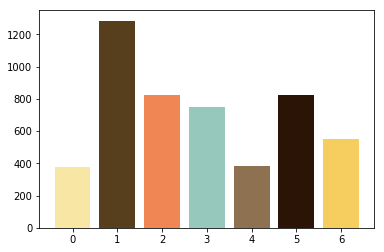

In [12]:
# show the lut and its colors
color_lut = np.uint8(kmeans.cluster_centers_)
plt.bar(np.arange(len(color_lut)), 
         np.unique(kmeans.labels_, return_counts=True)[1], 
         color=color_lut/255)
color_lut

In [13]:
# prof
test_recolored = np.full_like(poster, (255,255,255))  # fill the image with white
test_recolored[poster_mask] = color_lut[label_map]  # apply the LUT
test_recolored.shape

(5956, 4153, 3)

Text(0.5,1,'Recolored')

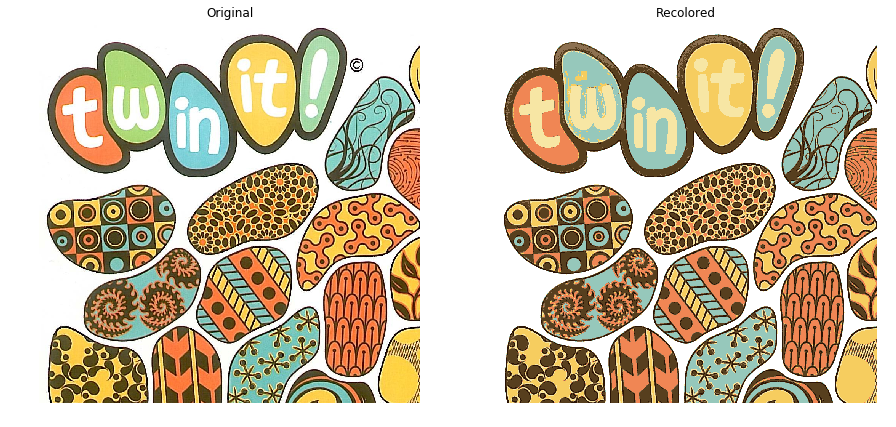

In [14]:
# let us display the images
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(poster[:1000,:1000])
plt.axis("off")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(test_recolored[:1000,:1000])
plt.axis("off")
plt.title("Recolored")

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Save the image and compare its size with the original one.**

Tip:
- Use shell magics to quickly call `du`.
</div>

In [15]:
# prof
# save the image and compare the sizes
cv2.imwrite("/tmp/recolored.png", cv2.cvtColor(test_recolored, cv2.COLOR_HSV2BGR))
!du -h /tmp/recolored.png
!du -h $PATH_TO_RESOURCES/twin_it_200dpi.png

15M	/tmp/recolored.png
46M	res/twin_it/twin_it_200dpi.png


### 1.5. Load and convert all the bubbles
We can now load and convert all the bubbles. We need to:
1. load them
2. convert them to the HSV color space
3. project their colors using the previous method

We will need to ignore the area where all the pixels are black, because it may change their value.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**First define a function to compute the mask of a bubble.**

Tip:
- It is a boolean image where $(x,y)$ is `True` as soon as the value of any channel of the original image, at $(x,y)$ is $> 0$.
</div>

In [16]:
# define a function to compute the mask of a bubble
def bubble2mask(bubble):
    return np.any(bubble>0, axis=-1) # = (bubble[...,0] > 0)*(bubble[...,1] > 0)*(bubble[...,2] > 0)

In [17]:
# Some Jupyter magic to help you
bubble_files = !ls $PATH_TO_RESOURCES/bubbles_200dpi/b*.png  | sort
bubble_files[:3]

['res/twin_it/bubbles_200dpi/b001.png',
 'res/twin_it/bubbles_200dpi/b002.png',
 'res/twin_it/bubbles_200dpi/b003.png']

In [18]:
bubbles = [skimage.io.imread(ff) for ff in bubble_files]
len(bubbles), bubbles[0].shape, bubbles[0].dtype

(391, (392, 787, 3), dtype('uint8'))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**And reduce the color of all bubbles.**
</div>

In [19]:
# prof
# reduce the color of all bubbles
bubbles_quant = []
for bb in bubbles:
    mask = bubble2mask(bb)
    recolored = np.zeros_like(bb)
    label_map = kmeans.predict(bb[mask])
    recolored[mask] = color_lut[label_map]
    bubbles_quant.append(recolored)

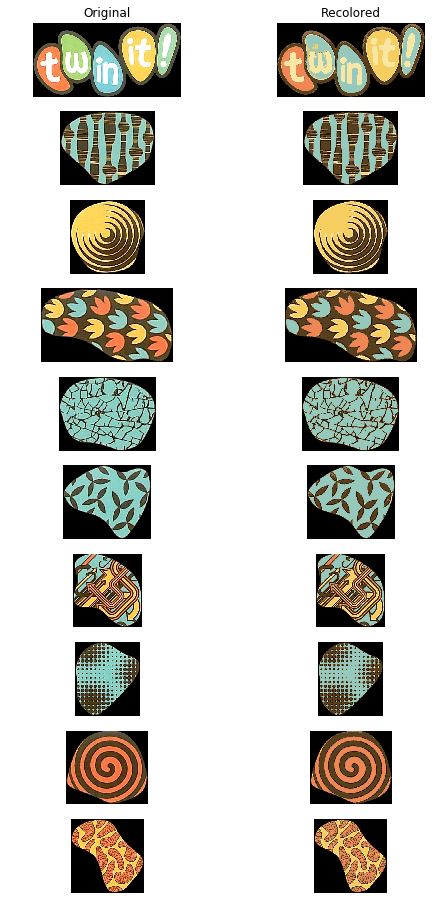

In [20]:
# let us display the images
plt.figure(figsize=(8,16))
for ii in range(10):
    plt.subplot(10,2,1+2*ii)
    plt.imshow(bubbles[ii])
    plt.axis("off")
    if ii == 0:
        plt.title("Original")
    plt.subplot(10,2,2+2*ii)
    plt.imshow(bubbles_quant[ii])
    plt.axis("off")
    if ii == 0:
        plt.title("Recolored")

## 2. Compute the color histograms
To compute the color histogram of a bubble, we do not need to recolorize it, we just need to compute its "label map".

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the color histogram for each bubble. Use [`np.bincount`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html#numpy.bincount) to count the number of number of occurence of each cluster label. Do not forget to normalize the histogram using the number of non-zero values in the mask with [`np.count_nonzero`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.count_nonzero.html).**
</div>

In [21]:
# prof
# compute the color histogram for each bubble
color_histograms = []
for bb in bubbles:
    mask = bubble2mask(bb)  
    label_map = kmeans.predict(bb[mask])
    bb_hist = np.bincount(label_map, minlength=kmeans.n_clusters) / np.count_nonzero(mask)
    color_histograms.append(bb_hist)

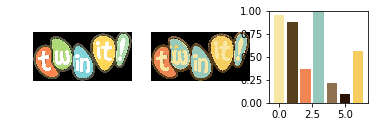

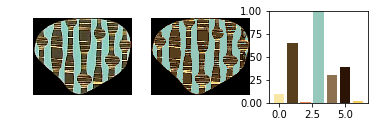

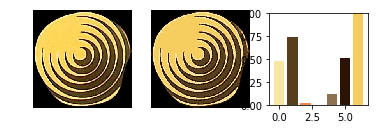

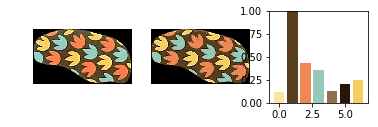

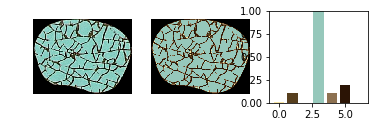

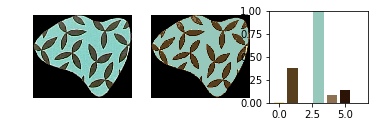

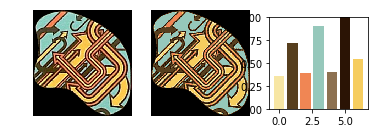

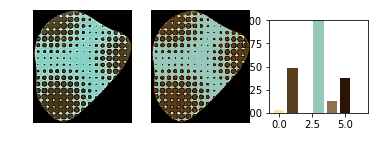

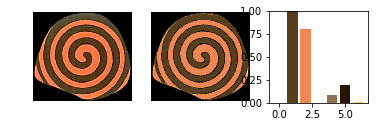

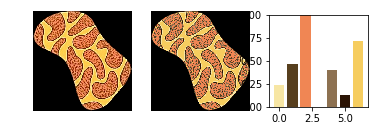

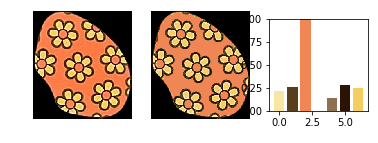

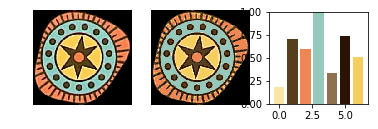

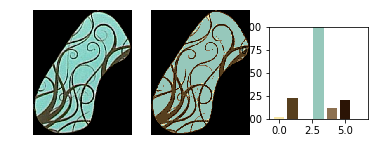

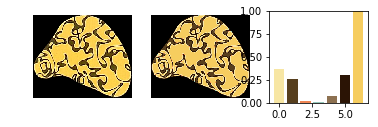

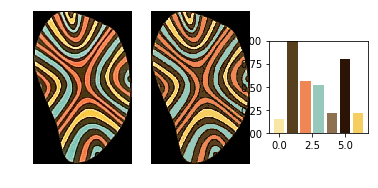

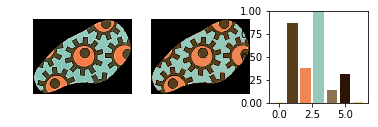

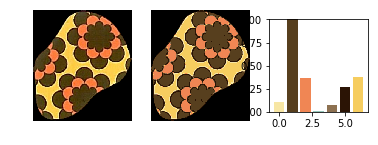

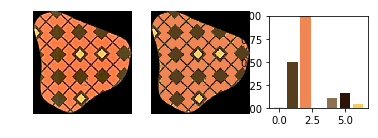

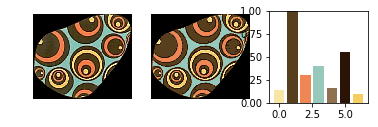

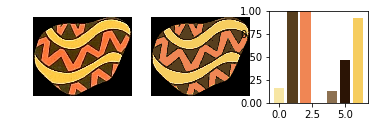

In [22]:
# Show some color histograms with colors!
colors_for_bars = color_lut/255
colors_for_bars = colors_for_bars.squeeze()
for ii in range(20):
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(bubbles[ii])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(bubbles_quant[ii])
    plt.axis('off')
    plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms[ii])), 
            color_histograms[ii]/color_histograms[ii].max(), 
            color=colors_for_bars)
    plt.show()

## 3. Compute the distance matrix
Because color histograms are **very compact**, it is **very fast** to compute the distance matrix (even if the complexity is $O(n^2)$).

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the distance matrix between each pair of bubbles. Use an appropriate distance from [`scipy.spatial.distance`](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html).**
</div>

In [24]:
# prof
# compute the distance matrix between each pair of bubbles
from scipy.spatial.distance import cosine as dist_cosine

dist_mat = np.empty((len(bubbles), len(bubbles)))  # distances will be between 0 (closest) and 1 (farthest)
max_elem = len(bubbles)
for ii in range(max_elem):
    for jj in range(max_elem):
        dist_mat[ii, jj] = dist_cosine(color_histograms[ii], color_histograms[jj])

In [25]:
np.set_printoptions(precision=3, edgeitems=4)
dist_mat[:,:]

array([[0.   , 0.232, 0.312, 0.213, ..., 0.335, 0.328, 0.489, 0.133],
       [0.232, 0.   , 0.581, 0.268, ..., 0.509, 0.263, 0.583, 0.091],
       [0.312, 0.581, 0.   , 0.32 , ..., 0.324, 0.412, 0.557, 0.307],
       [0.213, 0.268, 0.32 , 0.   , ..., 0.104, 0.048, 0.129, 0.152],
       ...,
       [0.335, 0.509, 0.324, 0.104, ..., 0.   , 0.201, 0.067, 0.276],
       [0.328, 0.263, 0.412, 0.048, ..., 0.201, 0.   , 0.207, 0.168],
       [0.489, 0.583, 0.557, 0.129, ..., 0.067, 0.207, 0.   , 0.441],
       [0.133, 0.091, 0.307, 0.152, ..., 0.276, 0.168, 0.441, 0.   ]])

Correct the diagonal to avoid getting the same result over and over: we set the distance of one element against itself to the maximum distance.

In [26]:
dist_mat[np.diag_indices_from(dist_mat)] = 1

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Display the best matches for some (all?) bubbles, ie the bubbles which are the closest to a given one. Use `np.argsort` along the appropriate axis to get the indices of the closest elements along each line.**
</div>

In [27]:
# TODO Display the best matches for some bubbles
best_matches_idx_perrow = None

0 186:0.069 181:0.084 148:0.109 372:0.117 


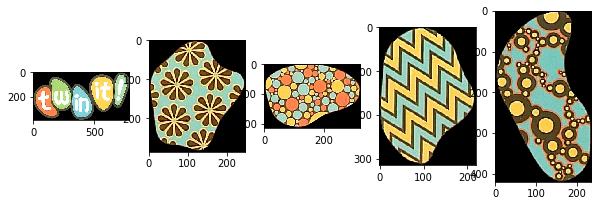

1 377:0.012 311:0.013 107:0.014 7:0.015 


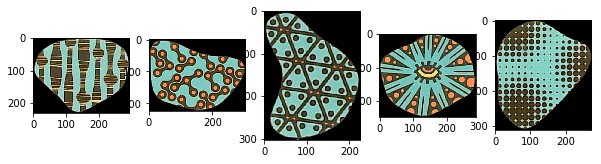

35 219:0.002 335:0.006 362:0.023 251:0.030 


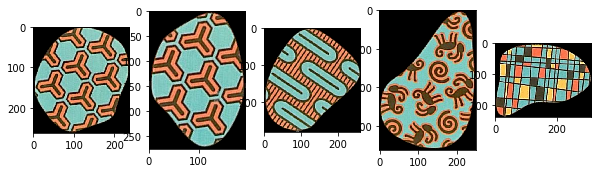

36 304:0.024 69:0.027 155:0.033 212:0.035 


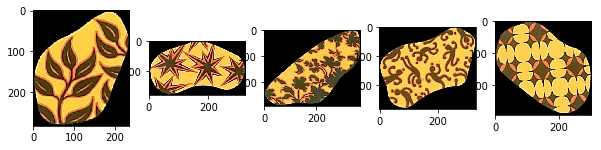

43 291:0.013 347:0.022 133:0.022 363:0.025 


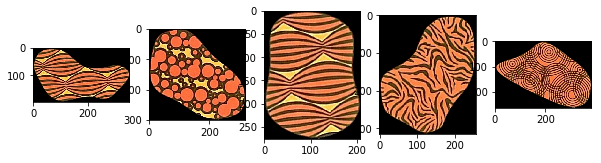

44 222:0.023 252:0.036 304:0.058 245:0.058 


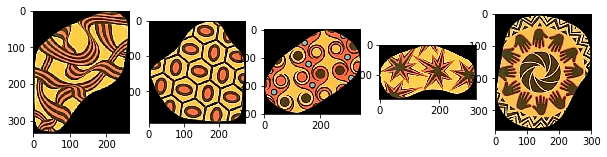

49 278:0.001 175:0.009 149:0.021 180:0.022 


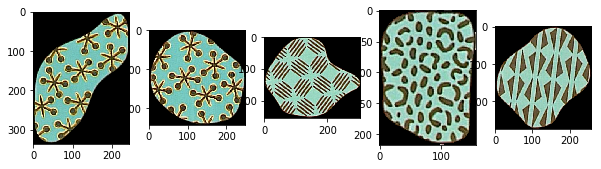

50 10:0.017 284:0.019 354:0.022 88:0.029 


91 45:0.004 145:0.004 337:0.004 73:0.007 


92 340:0.013 388:0.015 56:0.015 18:0.021 


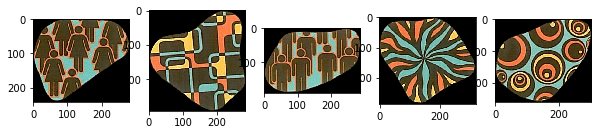

105 229:0.000 164:0.003 193:0.003 389:0.003 


106 329:0.003 126:0.010 55:0.011 253:0.017 


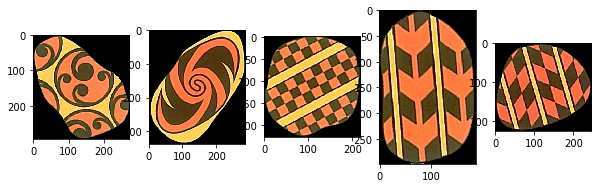

In [28]:
# prof
# Display the best matches for some bubbles
def imshow_raw(imlist, columns=5):
    plt.figure(figsize=(10,10))
    for ii, image in enumerate(imlist):
        plt.subplot((len(imlist) + columns - 1) // columns, columns, ii+1)
        plt.imshow(image)
    plt.show()

best_matches_idx_perrow = np.argsort(dist_mat, axis=1)

max_res = 4
for ii in [0, 1, 35, 36, 43, 44, 49, 50, 91, 92, 105, 106]:
    str_to_print = "%d "%ii
    bb_to_display = [bubbles[ii]]
    for jj in range(max_res):
        bb_idx = best_matches_idx_perrow[ii, jj]
        str_to_print += "%i:%.3f " % (bb_idx, dist_mat[ii, bb_idx])
        bb_to_display.append(bubbles[bb_idx])
    print(str_to_print)
    imshow_raw(bb_to_display)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Write some notes about the advantages and the limitations of the color histogram approach.**
</div>

Advantages of color hist:
- very fast
- very compact descriptor
- rotation invariance (not demonstrated here)

Limitations:
- limited descriptive power
- sensible to cropping

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Save the distance matrix somewhere as it will be useful later.**
</div>

In [29]:
# prof
# save the distance matrix (we also save the color histograms here)
color_histograms = np.array(color_histograms)
dist_mat = np.array(dist_mat)
print(type(color_histograms), color_histograms.shape, color_histograms.dtype)
print(type(dist_mat), dist_mat.shape, dist_mat.dtype)
np.savez_compressed("/tmp/bubble_dist_mat_hsv7-cosine.npz", color_histograms=color_histograms, dist_mat=dist_mat)

<class 'numpy.ndarray'> (391, 7) float64
<class 'numpy.ndarray'> (391, 391) float64


## 4. Hierarchical clustering and dendrograms
Instead of computing a distance matrix, it is also possible to aggregate the elements starting by the closest one, then iterating. The trick is to be able to compute the distance between a cluster and another cluster, and a simple solution is to average the descriptor of two clusters to form the descriptor of a new parent cluster.

The code below does all this work and produces a dendrogram.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Call the functions (2nd and 3rd cells below) appropriately to generate a beautiful image.**
</div>

In [30]:
# Adapted from https://github.com/jesolem/PCV/blob/master/PCV/clustering/hcluster.py
# licensed under the BSD 2-Clause "Simplified" License
from itertools import combinations

class ClusterNode(object):
    def __init__(self,vec,left,right,distance=0.0,count=1):
        self.left = left
        self.right = right
        self.vec = vec
        self.distance = distance
        self.count = count # only used for weighted average

    def extract_clusters(self,dist):
        """ Extract list of sub-tree clusters from 
            hcluster tree with distance<dist. """
        if self.distance < dist:
            return [self]
        return self.left.extract_clusters(dist) + self.right.extract_clusters(dist)

    def get_cluster_elements(self):
        """    Return ids for elements in a cluster sub-tree. """
        return self.left.get_cluster_elements() + self.right.get_cluster_elements()

    def get_height(self):
        """    Return the height of a node, 
            height is sum of each branch. """
        return self.left.get_height() + self.right.get_height()

    def get_depth(self):
        """    Return the depth of a node, depth is 
            max of each child plus own distance. """
        return max(self.left.get_depth(), self.right.get_depth()) + self.distance

    def draw(self,draw,x,y,s,imlist,im):
        """    Draw nodes recursively with image 
            thumbnails for leaf nodes. """
        h1 = int(self.left.get_height()*60 / 2)
        h2 = int(self.right.get_height()*60 /2)
        top = y-(h1+h2)
        bottom = y+(h1+h2)
        
        # vertical line to children
        cv2.line(draw, (int(top+h1), int(x)) , (int(bottom-h2),int(x)), (0,0,0))
        
        # horizontal lines 
        ll = self.distance*s
        cv2.line(draw, (int(top+h1),int(x)) , (int(top+h1), int(x+ll)), (0,0,0))
        cv2.line(draw, (int(bottom-h2), int(x)) , (int(bottom-h2), int(x+ll)), (0,0,0))
        
        # draw left and right child nodes recursively    
        self.left.draw(draw,x+ll,top+h1,s,imlist,im)
        self.right.draw(draw,x+ll,bottom-h2,s,imlist,im)
    

class ClusterLeafNode(object):
    def __init__(self,vec,id):
        self.vec = vec
        self.id = id

    def extract_clusters(self,dist):
        return [self] 

    def get_cluster_elements(self):
        return [self.id]

    def get_height(self):
        return 1

    def get_depth(self):
        return 0
    
    def draw(self,draw,x,y,s,imlist,im):
        nodeim = cv2.resize(imlist[self.id], (60,60))
        ns = nodeim.shape
        im[int(x):int(x+ns[0]), int(y-ns[1]//2):int(y+ns[1]-ns[1]//2), ...] = nodeim


def hcluster(features,distfcn):
    """ Cluster the rows of features using 
        hierarchical clustering. """
    
    # cache of distance calculations
    distances = {}
    
    # initialize with each row as a cluster 
    node = [ClusterLeafNode(f,id=i) for i,f in enumerate(features)]
    
    while len(node)>1:
        closest = float('Inf')
        
        # loop through every pair looking for the smallest distance
        for ni,nj in combinations(node,2):
            if (ni,nj) not in distances: 
                distances[ni,nj] = distfcn(ni.vec,nj.vec)
                
            d = distances[ni,nj]
            if d<closest:
                closest = d 
                lowestpair = (ni,nj)
        ni,nj = lowestpair
        
        # average the two clusters
        new_vec = (ni.vec + nj.vec) / 2.0
        
        # create new node
        new_node = ClusterNode(new_vec,left=ni,right=nj,distance=closest)
        node.remove(ni)
        node.remove(nj)
        node.append(new_node)
    
    return node[0]

 
def draw_dendrogram(node,imlist,filename='dendrogram.jpg'):
    """ Draw a cluster dendrogram and save to a file. """
    # height and width
    cols = node.get_height()*60
    rows = 1200

    # scale factor for distances to fit image width
    s = float(rows-150)/node.get_depth()
    
    # create image and draw object
    im = np.full((rows,cols, 3), 255, dtype=np.uint8)
    draw = im
    
    # initial line for start of tree 
    cv2.line(draw, (cols//2, 0),(cols//2, 60), (0,0,0))
    
    # draw the nodes recursively
    node.draw(draw,60,(cols/2),s,imlist,im)
    cv2.imwrite(filename, draw)
    print("Wrote '%s'." % filename)

In [31]:
# prof
# generate the clusters
cluster = hcluster(color_histograms, distfcn=dist_cosine)

In [32]:
draw_dendrogram(cluster, bubbles, "/tmp/dendrogram.jpg")

Wrote '/tmp/dendrogram.jpg'.


# Job done!
Now you're ready to move on to the next stage: [Keypoint detection and description](practice_02-02_detection-description.ipynb).